In [1]:
from tqdm import tqdm

In [2]:
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl

In [3]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import math
import skopt

In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 50)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_seq_items', 50)
pd.set_option('display.width', 100)

In [341]:
#chargement des base de données
df_geolocation = pd.read_csv('Data/olist_geolocation_dataset.csv')
df_orders = pd.read_csv('Data/olist_orders_dataset.csv')
df_order_items = pd.read_csv('Data/olist_order_items_dataset.csv')
df_order_reviews = pd.read_csv('Data/olist_order_reviews_dataset.csv')
df_customers = pd.read_csv('Data/olist_customers_dataset.csv')
df_order_payments = pd.read_csv('Data/olist_order_payments_dataset.csv')
df_products = pd.read_csv('Data/olist_products_dataset.csv')
df_sellers = pd.read_csv('Data/olist_sellers_dataset.csv')
df_product_category_name = pd.read_csv('Data/product_category_name_translation.csv')

## Fonctions

In [ ]:
def deg2rad(x):
    return math.pi*x/180

def get_distance_m(lat1, lng1, lat2, lng2):
    earth_radius = 6378137   # Terre = sphère de 6378km de rayon
    rlo1 = deg2rad(lng1)    # CONVERSION
    rla1 = deg2rad(lat1)
    rlo2 = deg2rad(lng2)
    rla2 = deg2rad(lat2)
    dlo = (rlo2 - rlo1) / 2
    dla = (rla2 - rla1) / 2
    a = (np.sin(dla) * np.sin(dla)) + np.cos(rla1) * np.cos(rla2) * (np.sin(dlo) * np.sin(dlo))
    d = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return (earth_radius * d)

## Nettoyage de base

In [342]:
# prepare customers
df_geolocation = df_geolocation.groupby(['geolocation_zip_code_prefix']).mean()
df_customers = df_customers.merge(df_geolocation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')

# prépare order
df_orders = df_orders.merge(df_customers[['customer_unique_id', 'customer_id']], on='customer_id')
df_orders = df_orders.merge(df_order_reviews, on='order_id', how='left')
# keep only last review if multiple
df_orders = df_orders.sort_values(by='review_answer_timestamp').drop_duplicates(subset=['order_id'], keep='last')

for i in df_order_payments.index:
    df_order_payments.loc[i,df_order_payments.loc[i,'payment_type']] = df_order_payments.loc[i,'payment_value']
df_order_payments.fillna(0, inplace=True)
df_payment = pd.DataFrame({'order_id' : df_order_payments['order_id'].value_counts().index, 'number_of_payment' : df_order_payments['order_id'].value_counts()})
df_payment = df_payment.merge(df_order_payments[['order_id', 'payment_value', 'boleto', 'credit_card', 'debit_card', 'not_defined', 'voucher']].groupby('order_id').sum(), on='order_id')
df_orders = df_orders.merge(df_payment, on='order_id')

# prépare order items
df_sellers = df_sellers.merge(df_geolocation, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
df_products = df_products.merge(df_product_category_name, on='product_category_name', how='left')
df_order_items = df_order_items.merge(df_sellers, on='seller_id', how='left')
df_order_items = df_order_items.merge(df_products, on='product_id', how='left')
df_order_items = df_order_items.merge(df_orders[['order_id', 'customer_unique_id']], on='order_id')

In [343]:
# df_customers
df_customers['customer_city'] = df['customer_city'].str.title()

In [344]:
# df_orders
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_creation_date', 'review_answer_timestamp']
for col in date_columns:
    df_orders[col] = pd.to_datetime(df_orders[col], format='%Y-%m-%d %H:%M:%S')


df_orders['order_status'] = df_orders['order_status'].str.title()
# Engineering new/essential columns
df_orders['order_purchase_year'] = df_orders.order_purchase_timestamp.apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders.order_purchase_timestamp.apply(lambda x: x.month)
df_orders['order_purchase_dayofweek'] = df_orders.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df_orders['order_purchase_hour'] = df_orders.order_purchase_timestamp.apply(lambda x: x.hour)
df_orders['order_purchase_day'] = df_orders['order_purchase_dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df_orders['order_purchase_mon'] = df_orders.order_purchase_timestamp.apply(lambda x: x.month).map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})


In [345]:
# Extracting attributes for purchase date - Time of the Day
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# Changing the month attribute for correct ordenation
df_orders['month_year'] = df_orders['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
df_orders['month_year'] = df_orders['order_purchase_year'].astype(str) + '-' + df_orders['month_year'].astype(str)
# Creating year month column
df_orders['month_y'] = df_orders['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)

In [346]:
# df_order_items
df_order_items['seller_city'] = df_order_items['seller_city'].str.title()
df_order_items['product_category_name'] = df_order_items['product_category_name'].str.replace('_', ' ').str.title()
df_order_items['product_category_name_english'] = df_order_items['product_category_name_english'].str.replace('_', ' ').str.title()

In [347]:
# relative time
df_orders['delivery_against_estimated'] = (df_orders['order_estimated_delivery_date'] - df_orders['order_delivered_customer_date']).astype('timedelta64[h]')/24
df_orders['order_approved_timelapse'] = (df_orders['order_approved_at'] - df_orders['order_purchase_timestamp']).astype('timedelta64[h]')
df_orders['order_delivered_carrier_timelapse'] = (df_orders['order_delivered_carrier_date'] - df_orders['order_purchase_timestamp']).astype('timedelta64[h]')/24
df_orders['order_delivered_customer_timelapse'] = (df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp']).astype('timedelta64[h]')/24
df_orders['order_estimated_delivery_timelapse'] = (df_orders['order_estimated_delivery_date'] - df_orders['order_purchase_timestamp']).astype('timedelta64[h]')/24
df_orders['review_creation_timelapse_from_delivery'] = (df_orders['review_creation_date'] - df_orders['order_delivered_customer_date']).astype('timedelta64[m]')
df_orders['review_answer_timeslapse_from_review'] = (df_orders['review_answer_timestamp'] - df_orders['review_creation_date']).astype('timedelta64[h]')

In [348]:
df_orders.drop(['review_comment_title', 'review_comment_message'], axis=1, inplace=True)

df_order_items['product_category_name_english'].fillna('unknown', inplace=True)



df_orders = df_orders[df_orders['order_status'] == 'Delivered']
df_orders.drop(['order_status'], axis=1, inplace=True)

df_orders.dropna(inplace=True)

In [349]:
df_onehot = pd.get_dummies(df_orders[['order_purchase_day', 'order_purchase_mon', 'order_purchase_time_day']], prefix=['order_purchase_day', 'order_purchase_mon', 'order_purchase_time_day'])
df_orders = df_orders.join(df_onehot)

### réel df_cust

In [420]:
df = pd.DataFrame({'customer_unique_id' : df_customers['customer_unique_id'].value_counts().index})

In [421]:
df.shape

(95828, 1)

In [422]:
df = df.merge(df_customers.groupby('customer_unique_id').first()[['customer_city', 'customer_state', 'geolocation_lat', 'geolocation_lng']], on='customer_unique_id')

In [423]:
order_agg = {'customer_id': 'count',
            'order_purchase_timestamp': 'max',
            'review_score': 'mean',
            'number_of_payment': 'sum',
            'payment_value': 'sum',
            'boleto': 'sum',
            'credit_card': 'sum',
            'debit_card': 'sum',
            'not_defined': 'sum',
            'voucher': 'sum',
            'delivery_against_estimated': 'mean',
            'order_approved_timelapse': 'mean',
            'order_delivered_carrier_timelapse': 'mean',
            'order_delivered_customer_timelapse': 'mean',
            'order_estimated_delivery_timelapse': 'mean',
            'review_creation_timelapse_from_delivery': 'mean',
            'review_answer_timeslapse_from_review': 'mean'
            }
df = df.merge(df_orders.groupby('customer_unique_id').agg(order_agg), on='customer_unique_id')

In [424]:
df = df.merge(df_orders.iloc[:,35:].join(df_orders['customer_unique_id']).groupby('customer_unique_id').sum(), on='customer_unique_id')

In [425]:
df_order_items = df_order_items.merge(df[['customer_unique_id', 'geolocation_lat', 'geolocation_lng']], on="customer_unique_id", suffixes=('_seller', '_customer'))

In [426]:
df_order_items['euclidean_distance'] = math.pi*np.sqrt(((df_order_items['geolocation_lat_seller']-df_order_items['geolocation_lat_customer'])**2+(df_order_items['geolocation_lng_seller']-df_order_items['geolocation_lng_customer'])**2))/180 * 6378137

In [427]:
df_order_items['orthodromique_distance'] = get_distance_m(df_order_items['geolocation_lat_seller'], df_order_items['geolocation_lng_seller'], df_order_items['geolocation_lat_customer'], df_order_items['geolocation_lng_customer'])

<AxesSubplot:ylabel='Frequency'>

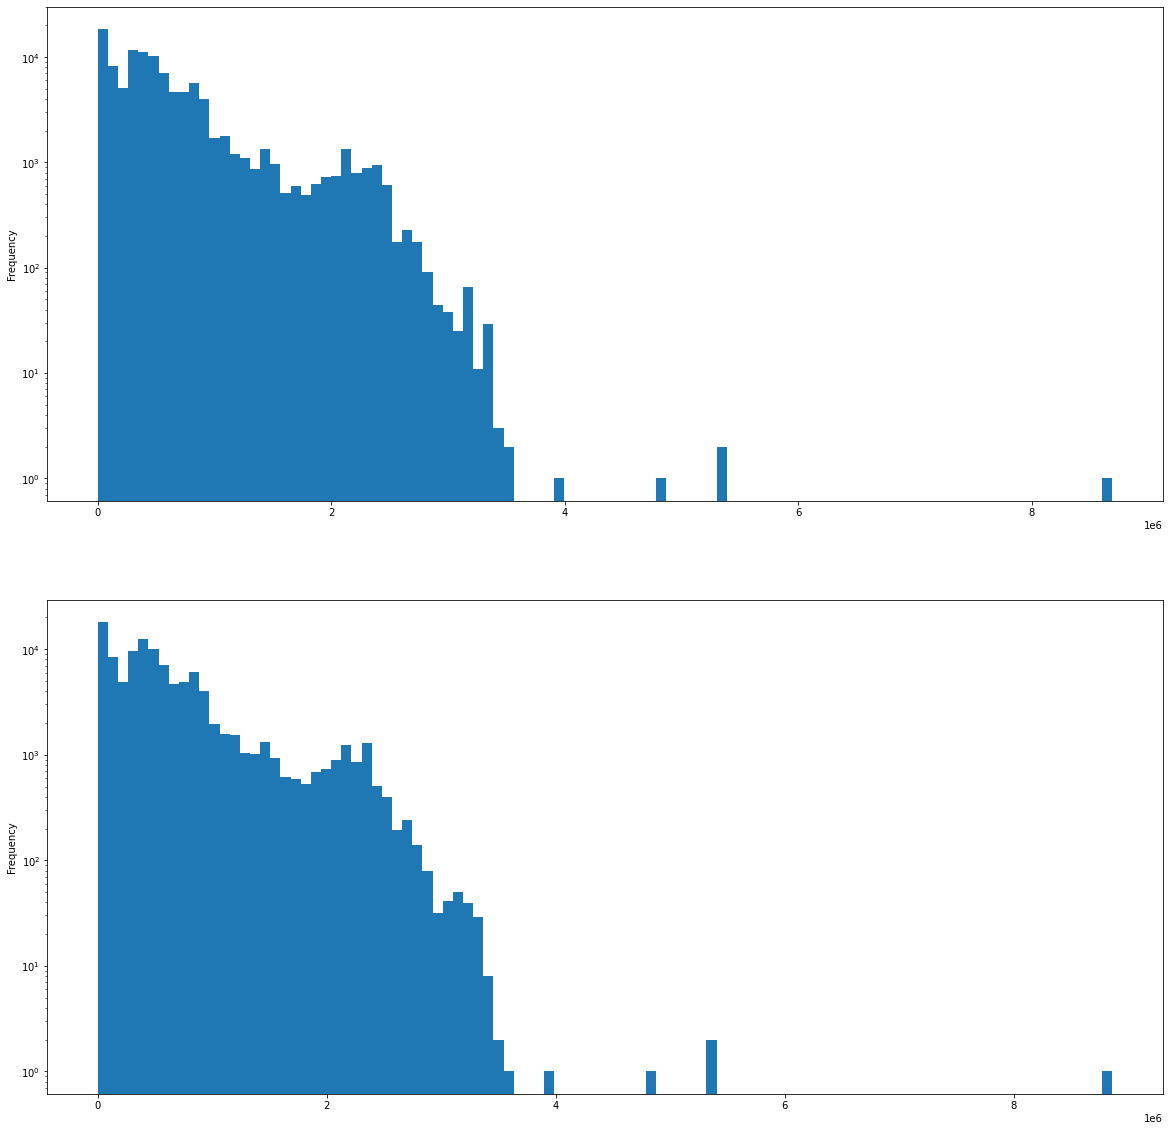

In [428]:
plt.figure(figsize=(20,20))
plt.subplot(211)
df_order_items['orthodromique_distance'].plot.hist(bins=100,logy=True)
plt.subplot(212)
df_order_items['euclidean_distance'].plot.hist(bins=100,logy=True)

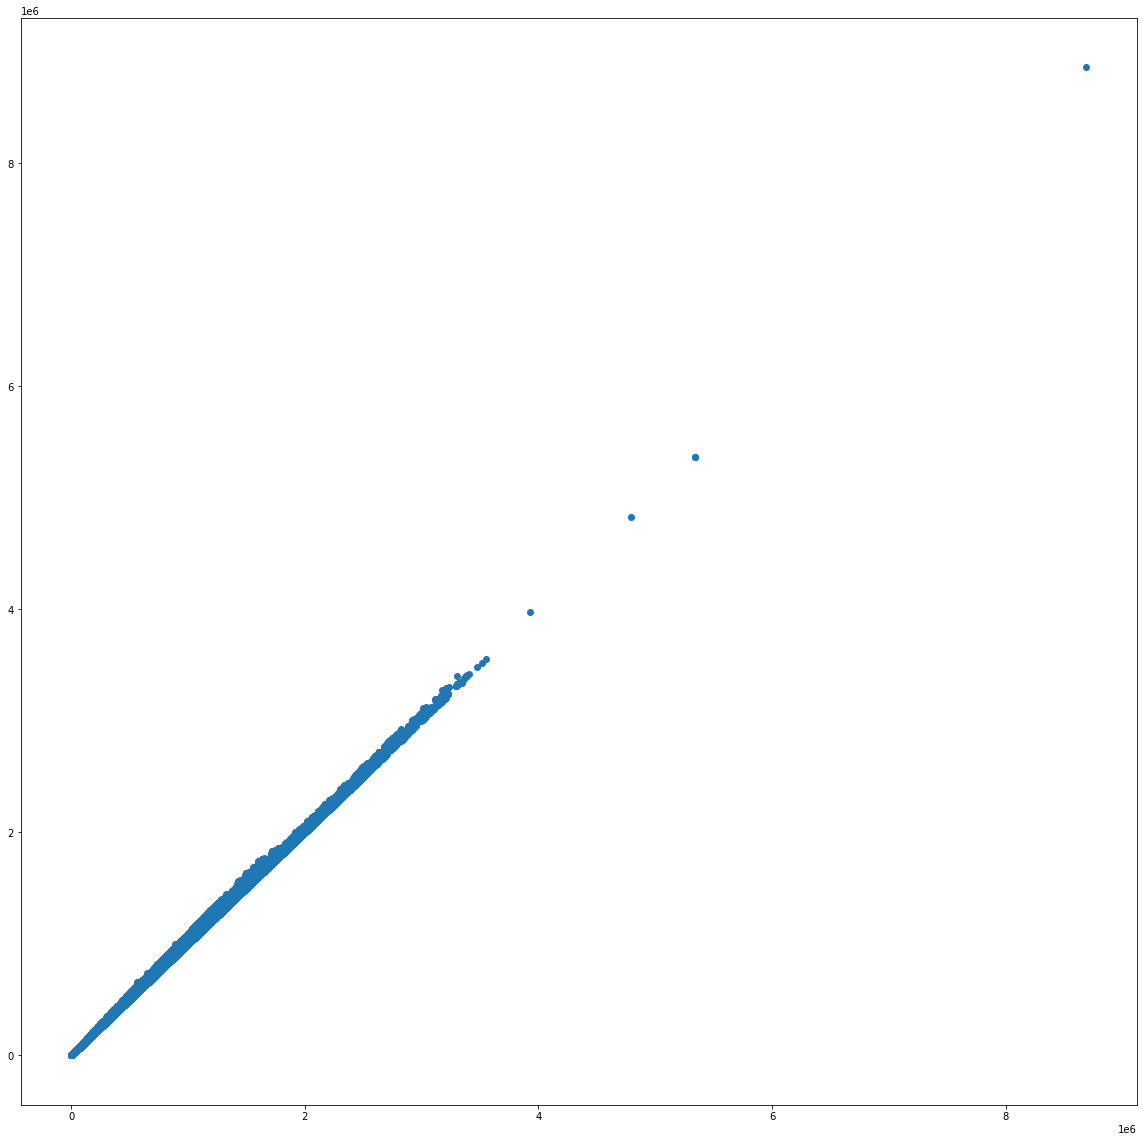

In [429]:
plt.figure(figsize=(20,20))
plt.scatter(df_order_items['orthodromique_distance'], df_order_items['euclidean_distance'])

In [430]:
df_order_items['orthodromique_distance_log'] = np.log(df_order_items['orthodromique_distance']+1)

In [431]:
df_order_items['product_volume'] = df_order_items['product_height_cm'] * df_order_items['product_length_cm'] * df_order_items['product_width_cm']

In [432]:
df_order_items[['product_volume_log', 'product_weight_g_log']] = np.log(df_order_items[['product_volume', 'product_weight_g']]+1)

<AxesSubplot:>

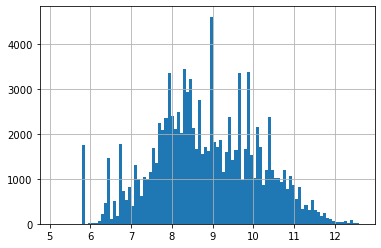

In [433]:
df_order_items['product_volume_log'].hist(bins=100)

<AxesSubplot:>

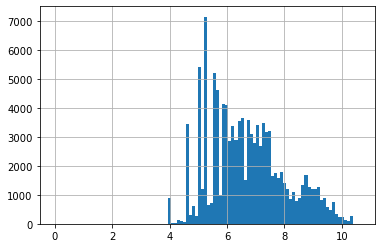

In [434]:
df_order_items['product_weight_g_log'].hist(bins=100)

In [438]:
order_agg = {'price': 'mean',
             'freight_value': 'sum',
             'product_name_lenght': 'mean',
             'product_description_lenght': 'mean',
             'product_photos_qty': 'mean',
             'orthodromique_distance_log': 'mean',
             'product_volume_log': 'mean',
             'product_weight_g_log': 'mean'
            }
df = df.merge(df_order_items.groupby('customer_unique_id').agg(order_agg), on='customer_unique_id')

In [ ]:
df_cust.rename(columns={'customer_id': 'frequency',
                        'order_purchase_timestamp': 'recency',
                        'payment_value': 'revenue',
                        'price': 'mean_price',
                        'freight_value': 'mean_freight_value'
                       })

In [439]:
df

,customer_unique_id,customer_city,customer_state,geolocation_lat,geolocation_lng,customer_id,order_purchase_timestamp,review_score,number_of_payment,payment_value,boleto,credit_card,debit_card,not_defined,voucher,delivery_against_estimated,order_approved_timelapse,order_delivered_carrier_timelapse,order_delivered_customer_timelapse,order_estimated_delivery_timelapse,review_creation_timelapse_from_delivery,review_answer_timeslapse_from_review,order_purchase_day_Fri,order_purchase_day_Mon,order_purchase_day_Sat,order_purchase_day_Sun,order_purchase_day_Thu,order_purchase_day_Tue,order_purchase_day_Wed,order_purchase_mon_Apr,order_purchase_mon_Aug,order_purchase_mon_Dec,order_purchase_mon_Feb,order_purchase_mon_Jan,order_purchase_mon_Jul,order_purchase_mon_Jun,order_purchase_mon_Mar,order_purchase_mon_May,order_purchase_mon_Nov,order_purchase_mon_Oct,order_purchase_mon_Sep,order_purchase_time_day_Dawn,order_purchase_time_day_Morning,order_purchase_time_day_Afternoon,order_purchase_time_day_Night,price_x,freight_value_x,product_name_lenght_x,product_description_lenght_x,product_photos_qty_x,orthodromique_distance_log_x,product_volume_log_x,product_weight_g_log_x,price_y,freight_value_y,product_name_lenght_y,product_description_lenght_y,product_photos_qty_y,orthodromique_distance_log_y,product_volume_log_y,product_weight_g_log_y
0,8d50f5eadf50201ccdcedfb9e2ac8455,Sao Paulo,SP,-23.618666,-46.639583,15,2018-08-20 19:14:26,5.000000,15,879.27,0.00,879.27,0.0,0.0,0.00,8.333333,2.200000,1.347222,4.011111,12.663889,545.400000,28.600000,0,4,2,2,0,4,3,0,4,0,0,0,4,1,0,2,1,2,1,0,2,1,12,45.601250,172.42,40.266667,397.666667,2.200000,10.329890,8.375261,5.669621,45.601250,172.42,40.266667,397.666667,2.200000,10.329890,8.375261,5.669621
1,3e43e6105506432c953e165fb2acf44c,Guarai,SP,-24.008923,-46.419125,9,2018-02-27 18:36:39,2.777778,9,1172.66,0.00,1172.66,0.0,0.0,0.00,8.222222,3.444444,5.055556,14.106481,22.472222,2277.888889,41.222222,3,3,0,0,1,2,0,0,0,3,4,1,0,0,0,0,0,0,1,0,5,2,2,71.489286,171.82,45.428571,486.571429,1.428571,11.794079,8.538510,6.418344,71.489286,171.82,45.428571,486.571429,1.428571,11.794079,8.538510,6.418344
2,6469f99c1f9dfae7733b25662e7f1782,Sao Paulo,SP,-23.965227,-46.343581,7,2018-06-28 00:43:34,5.000000,7,758.83,0.00,758.83,0.0,0.0,0.00,13.000000,0.000000,1.476190,4.244048,17.458333,308.428571,24.285714,0,2,0,0,2,2,1,0,0,2,0,1,0,1,0,0,1,1,1,2,1,2,2,73.800000,94.63,56.555556,319.222222,1.333333,12.162369,7.730991,6.528441,73.800000,94.63,56.555556,319.222222,1.333333,12.162369,7.730991,6.528441
3,1b6c7548a2a1f9037c1fd3ddfed95f33,Missal,MG,-18.953619,-49.458176,7,2018-02-14 13:22:12,5.000000,8,959.01,781.15,149.14,0.0,0.0,28.72,11.714286,10.000000,2.053571,13.315476,25.261905,342.285714,42.571429,1,2,0,0,1,1,2,0,0,3,1,1,0,0,0,0,2,0,0,0,3,3,1,89.912222,149.80,45.333333,463.444444,3.777778,13.285825,9.179097,6.987210,89.912222,149.80,45.333333,463.444444,3.777778,13.285825,9.179097,6.987210
4,ca77025e7201e3b30c44b472ff346268,Casimiro De Abreu,PE,-8.125613,-34.902732,7,2018-06-01 11:38:29,5.000000,7,1122.72,383.27,739.45,0.0,0.0,0.00,14.714286,6.714286,3.797619,16.785714,31.785714,3286.000000,27.142857,2,1,1,0,3,0,0,1,0,0,2,1,0,1,0,1,0,1,0,2,3,1,1,67.217500,316.11,45.166667,235.166667,1.916667,14.559457,8.809665,7.128780,67.217500,316.11,45.166667,235.166667,1.916667,14.559457,8.809665,7.128780
5,47c1a3033b8b77b3ab6e109eb4d5fdf3,Cachoeiras De Macacu,SP,-23.548180,-46.910360,6,2018-01-24 15:15:26,4.833333,6,944.21,944.21,0.00,0.0,0.0,0.00,8.500000,17.166667,4.020833,12.736111,21.576389,-2638.666667,54.500000,0,3,0,0,0,1,2,0,3,0,0,1,0,0,0,0,1,0,1,0,2,4,0,119.514286,107.61,56.142857,841.142857,2.142857,11.876209,9.035162,6.792807,119.514286,107.61,56.142857,841.142857,2.142857,11.876209,9.035162,6.792807
6,12f5d6e1cbf93dafd9dcc19095df0b3d,Ourinhos,PR,-25.396576,-49.265762,6,2017-01-05 15:25:10,5.000000,6,110.72,110.72,0.00,0.0,0.0,0.00,22.500000,36.500000,6.034722,11.520833,34.361111,485.000000,11.500000,0,0,0,0,6,0,0,0,0,0,0,6,0,

## Convertion en df clients

In [235]:
print('\n '.join(df['product_category_name'].unique()))

Casa Construcao
 Automotivo
 Perfumaria
 Cama Mesa Banho
 Utilidades Domesticas
 Artes
 Esporte Lazer
 Ferramentas Jardim
 Eletronicos
 Sinalizacao E Seguranca
 Cool Stuff
 Relogios Presentes
 Bebes
 Moveis Decoracao
 Construcao Ferramentas Iluminacao
 Beleza Saude
 Moveis Escritorio
 Consoles Games
 Eletrodomesticos
 Telefonia
 Brinquedos
 Pet Shop
 Papelaria
 Livros Interesse Geral
 Informatica Acessorios
 Eletroportateis
 Fashion Bolsas E Acessorios
 Construcao Ferramentas Jardim
 Instrumentos Musicais
 Artigos De Natal
 Malas Acessorios
 Construcao Ferramentas Construcao
 Construcao Ferramentas Ferramentas
 Market Place
 Alimentos Bebidas
 Moveis Sala
 Casa Conforto
 Telefonia Fixa
 Audio
 Climatizacao
 Eletrodomesticos 2
 Fashion Esporte
 Moveis Cozinha Area De Servico Jantar E Jardim
 Construcao Ferramentas Seguranca
 Alimentos
 Industria Comercio E Negocios
 Pcs
 Bebidas
 Fashion Calcados
 Livros Importados
 Agro Industria E Comercio
 Livros Tecnicos
 Musica
 Fashion Roupa Mascu

In [73]:
df.head(10)

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat_customer,geolocation_lng_customer,review_id,review_score,review_creation_date,review_answer_timestamp,number_of_payment,payment_value,boleto,credit_card,debit_card,not_defined,voucher,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_seller,geolocation_lng_seller,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,delivery_against_estimated,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,order_purchase_time_day,month_year,month_y,shipping_timelapse,order_approved_timelapse,order_delivered_carrier_timelapse,order_delivered_customer_timelapse,order_estimated_delivery_timelapse,review_creation_timelapse_from_delivery,review_answer_timeslapse_from_review
342,bd50a7fe9fd97ea4b7663031a319e150,0975c3cf2e418ebfa5d1191a2dffd59d,2016-12-23 23:16:47,2016-12-23 23:31:37,2016-12-27 06:14:27,2016-12-28 15:54:44,2017-01-19,f7b981e8a280e455ac3cbe0d5d171bd1,80030.0,Curitiba,PR,-25.417039,-49.260760,19bede7c5c1b2ef2b85f4ba698c1cf54,5.0,2016-12-29,2016-12-30 11:52:57,1,19.62,0,1,0,0,0,1,f5d8f4fbc70ca2a0038b9a0010ed5cb0,48efc9d94a9834137efd9ea76b065a38,2016-12-27 23:16:47,10.90,8.72,81130,Curitiba,PR,-25.504915,-49.300034,Fashion Bolsas E Acessorios,64.0,1710.0,1.0,200.0,16.0,2.0,11.0,Fashion Bags Accessories,21.0,2016,12,4,23,Fri,Dec,Night,2016-12,201612,4.0,0.0,3.250000,4.666667,26.000000,485.0,35.0
350,ec7a019261fce44180373d45b442d78f,c24fc5f9a446b4d8262041b9c64de772,2017-01-05 11:56:06,2017-01-05 12:10:17,2017-01-06 12:43:41,2017-01-11 13:14:05,2017-02-01,f7b981e8a280e455ac3cbe0d5d171bd1,80030.0,Curitiba,PR,-25.417039,-49.260760,5f45d6aa32336fa26cbc254721c81880,5.0,2017-01-12,2017-01-13 20:22:46,1,19.62,0,1,0,0,0,1,f5d8f4fbc70ca2a0038b9a0010ed5cb0,48efc9d94a9834137efd9ea76b065a38,2017-01-09 11:56:06,10.90,8.72,81130,Curitiba,PR,-25.504915,-49.300034,Fashion Bolsas E Acessorios,64.0,1710.0,1.0,200.0,16.0,2.0,11.0,Fashion Bags Accessories,20.0,2017,1,3,11,Thu,Jan,Morning,2017-01,201701,4.0,0.0,1.000000,6.041667,26.500000,645.0,44.0
351,bf44408de1d05eef70fb026ba64a90ea,96054b94409f7712eeffe8edfa6959a6,2017-01-06 21:30:38,2017-01-10 03:10:35,2017-01-10 11:53:06,2017-01-12 09:43:56,2017-02-14,7122b4f327033b35961170342401066c,13270.0,Valinhos,SP,-22.975458,-47.002682,f23f447888d495a473a8e569ccd5b114,5.0,2017-01-13,2017-01-13 21:07:09,1,21.45,1,0,0,0,0,1,1a2d84c11fbc7b3d7c0a10206c085ce5,b76dba6c951ab00dc4edf0a1aa88037e,2017-01-10 21:30:38,10.49,10.96,3237,Sao Paulo,SP,-23.593455,-46.552356,Telefonia Fixa,44.0,333.0,3.0,100.0,16.0,4.0,11.0,Fixed Telephony,32.0,2017,1,4,21,Fri,Jan,Night,2017-01,201701,4.0,77.0,3.583333,5.500000,38.083333,856.0,21.0
352,e1fe072ef14b519af1f0a8ed997c1301,758b633d88b82063db189810084f4ea9,2017-01-05 15:32:59,2017-01-05 16:15:16,2017-01-06 13:45:22,2017-01-12 14:13:19,2017-02-15,4b3207464f5f7a48a7f63fa0b1251d86,14025.0,Ribeirao Preto,SP,-21.193638,-47.815198,49180505e856dbdac671d368b5135201,5.0,2017-01-13,2017-01-13 22:36:29,1,24.42,0,1,0,0,0,1,743801b34cc44776de511ba8eff778e2,48efc9d94a9834137efd9ea76b065a38,2017-01-09 15:32:59,9.90,14.52,81130,Curitiba,PR,-25.504915,-49.300034,Moveis Quarto,55.0,1939.0,2.0,200.0,16.0,2.0,11.0,Furniture Bedroom,33.0,2017,1,3,15,Thu,Jan,Afternoon,2017-01,201701,4.0,0.0,0.916667,6.916667,40.333333,586.0,22.0
353,f53b39c6c91ce86717c15d8e4e5da0c2,42d1b4eb863054dcb04a019944ecd2d8,2017-01-08 09:35:07,2017-01-10 03:10:46,2017-01-10 11:53:06,2017-01-12 09:22:12,2017-02-17,fc00da40808e113053d8a26c3e854ccf,22723.0,Rio De Janeiro,RJ,-22.916897,-43.402789,002fbdbf4b16

In [145]:
df_onehot = pd.get_dummies(df[['seller_state', 'customer_state', 'order_purchase_day', 'order_purchase_mon', 'order_purchase_time_day']], prefix=['seller_state', 'customer_state', 'order_purchase_day', 'order_purchase_mon', 'order_purchase_time_day'])
df = df.join(df_onehot)

In [146]:
df.shape

(106982, 133)

### début de df_cust

In [182]:
df_cust = pd.DataFrame({'customer_unique_id' : df['customer_unique_id'].value_counts().index, 'number_of_item_buy' : df['customer_unique_id'].value_counts()})

In [183]:
df_cust = df_cust.merge(df[['customer_unique_id', 'order_id']].groupby('order_id').first().value_counts().reset_index(level=[0]), on='customer_unique_id')

In [193]:
df[['customer_unique_id', 'order_id', 'review_score']].groupby('order_id').mean()

,review_score
order_id,
00010242fe8c5a6d1ba2dd792cb16214,5.0
00018f77f2f0320c557190d7a144bdd3,4.0
000229ec398224ef6ca0657da4fc703e,5.0
00024acbcdf0a6daa1e931b038114c75,4.0
00042b26cf59d7ce69dfabb4e55b4fd9,5.0
00048cc3ae777c65dbb7d2a0634bc1ea,4.0
00054e8431b9d7675808bcb819fb4a32,4.0
000576fe39319847cbb9d288c5617fa6,5.0
0005a1a1728c9d785b8e2b08b904576c,1.0


In [184]:
df_cust = df_cust.merge(df[['customer_unique_id', 'price', 'freight_value']].groupby(by='customer_unique_id').sum(), on='customer_unique_id')

In [185]:
df_cust = df_cust.merge(df[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').max(), on='customer_unique_id')

In [186]:
df_cust.rename(columns={0:'number_of_order', 'price':'total_price_of_items', 'freight_value':'total_freight_value', 'order_purchase_timestamp':'last_order'}, inplace=True)

In [191]:
list_groupby = ['customer_unique_id', 'customer_city', 'customer_state', 'geolocation_lat_customer', 'geolocation_lng_customer']
df_cust = df_cust.merge(df[list_groupby].groupby('customer_unique_id').first(), on='customer_unique_id')

In [192]:
df_cust.head()

,customer_unique_id,number_of_item_buy,number_of_order,total_price_of_items,total_freight_value,last_order,customer_city,customer_state,geolocation_lat_customer,geolocation_lng_customer
0,c8460e4251689ba205045f3ea17884a1,24,4,4080.00,575.88,2018-08-08 14:27:15,Porto Alegre,RS,-29.999995,-51.096263
1,4546caea018ad8c692964e3382debd19,21,1,31.80,164.37,2017-07-16 18:19:25,Sao Paulo,SP,-23.680743,-46.784224
2,c402f431464c72e27330a67f7b94d4fb,20,1,2000.00,202.40,2018-02-22 15:30:41,Sao Paulo,SP,-23.529825,-46.618174
3,0f5ac8d5c31de21d2f25e24be15bbffb,18,2,1252.35,292.47,2017-11-27 12:57:35,Uniao Da Vitoria,PR,-26.230550,-51.085926
4,eae0a83d752b1dd32697e0e7b4221656,15,2,1821.73,961.28,2018-04-24 17:06:54,Cicero Dantas,BA,-10.593072,-38.384993


## Analyse exploratoire

(array([0]), [Text(0, 0, '0')])

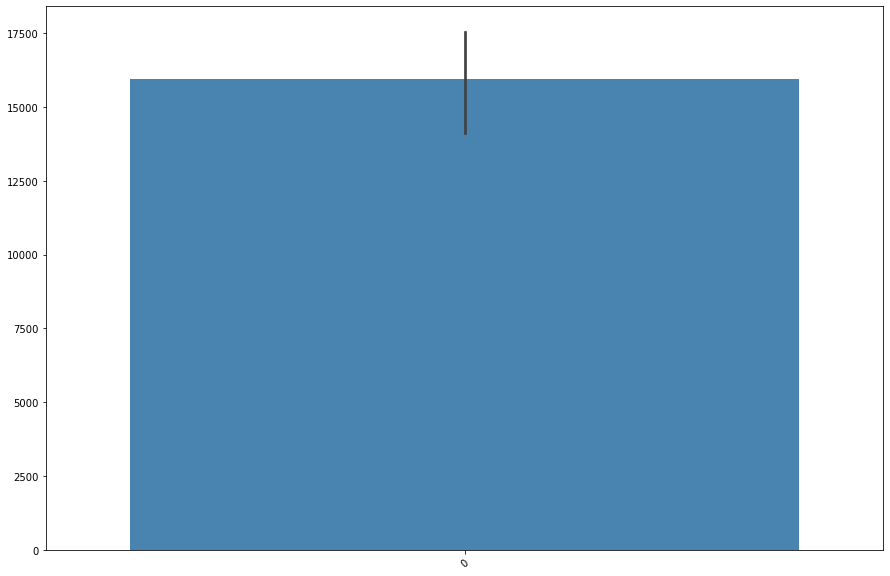

In [263]:
plt.figure(figsize=(15,10))
sns.barplot(data=df['order_purchase_day'].value_counts(), palette="Blues_d")
plt.xticks(rotation=40)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Fri'),
  Text(1, 0, 'Mon'),
  Text(2, 0, 'Sat'),
  Text(3, 0, 'Sun'),
  Text(4, 0, 'Thu'),
  Text(5, 0, 'Tue'),
  Text(6, 0, 'Wed')])

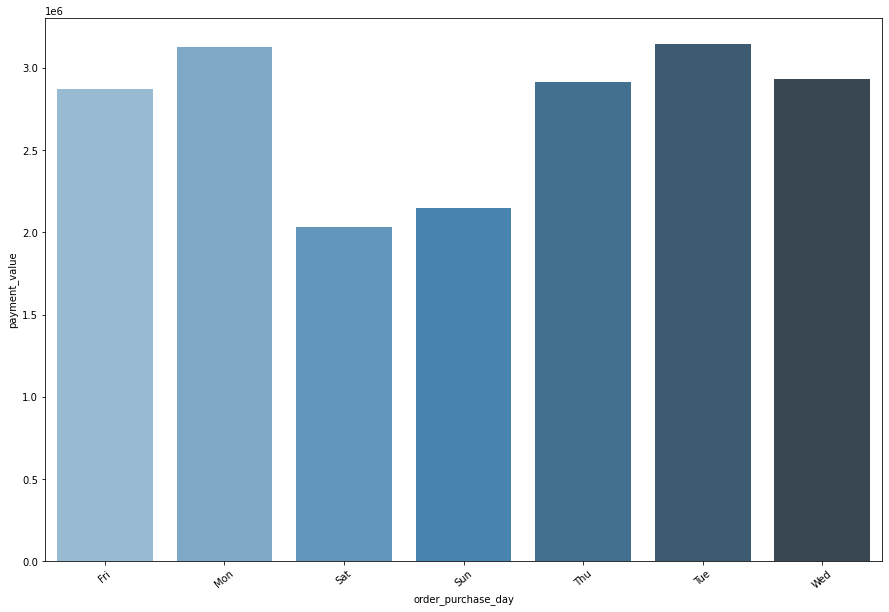

In [254]:
df_payement_v_month = df.groupby('order_purchase_day').sum()[['payment_value', 'price']].sort_index()
df_payement_v_month['order_purchase_day'] = df_payement_v_month.index
plt.figure(figsize=(15,10))
sns.barplot(data=df_payement_v_month, x='order_purchase_day', y='payment_value', palette="Blues_d")
plt.xticks(rotation=40)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Apr'),
  Text(1, 0, 'Aug'),
  Text(2, 0, 'Dec'),
  Text(3, 0, 'Feb'),
  Text(4, 0, 'Jan'),
  Text(5, 0, 'Jul'),
  Text(6, 0, 'Jun'),
  Text(7, 0, 'Mar'),
  Text(8, 0, 'May'),
  Text(9, 0, 'Nov'),
  Text(10, 0, 'Oct'),
  Text(11, 0, 'Sep')])

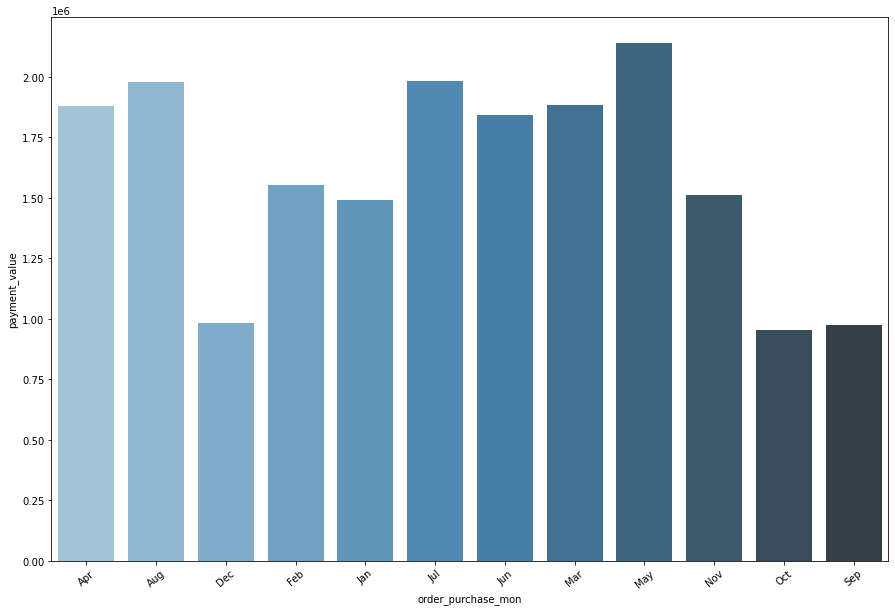

In [253]:
df_payement_v_month = df.groupby('order_purchase_mon').sum()[['payment_value', 'price']].sort_index()
df_payement_v_month['order_purchase_mon'] = df_payement_v_month.index
plt.figure(figsize=(15,10))
sns.barplot(data=df_payement_v_month, x='order_purchase_mon', y='payment_value', palette="Blues_d")
plt.xticks(rotation=40)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, '2016-12'),
  Text(1, 0, '2017-01'),
  Text(2, 0, '2017-02'),
  Text(3, 0, '2017-03'),
  Text(4, 0, '2017-04'),
  Text(5, 0, '2017-05'),
  Text(6, 0, '2017-06'),
  Text(7, 0, '2017-07'),
  Text(8, 0, '2017-08'),
  Text(9, 0, '2017-09'),
  Text(10, 0, '2017-10'),
  Text(11, 0, '2017-11'),
  Text(12, 0, '2017-12'),
  Text(13, 0, '2018-01'),
  Text(14, 0, '2018-02'),
  Text(15, 0, '2018-03'),
  Text(16, 0, '2018-04'),
  Text(17, 0, '2018-05'),
  Text(18, 0, '2018-06'),
  Text(19, 0, '2018-07'),
  Text(20, 0, '2018-08')])

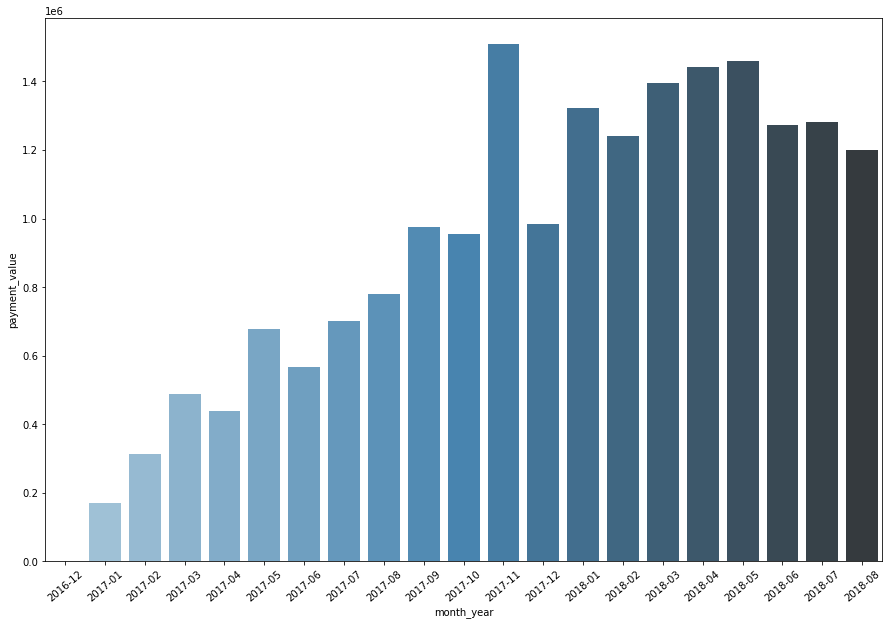

In [137]:
df_payement_v_month = df.groupby('month_year').sum()[['payment_value', 'price']].sort_index()
df_payement_v_month['month_year'] = df_payement_v_month.index
plt.figure(figsize=(15,10))
sns.barplot(data=df_payement_v_month, x='month_year', y='payment_value', palette="Blues_d")
plt.xticks(rotation=40)

<AxesSubplot:ylabel='payment_type'>

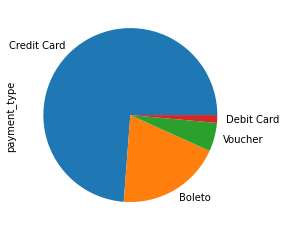

In [146]:
df['payment_type'].value_counts().plot.pie()

<AxesSubplot:ylabel='review_score'>

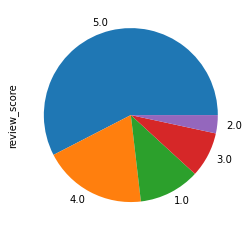

In [178]:
df['review_score'].value_counts().plot.pie()

<AxesSubplot:>

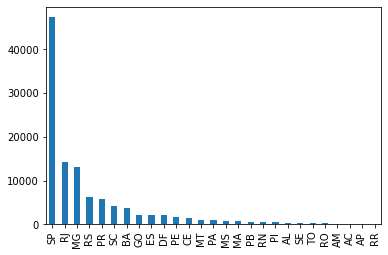

In [177]:
df['customer_state'].value_counts().plot.bar()

<AxesSubplot:>

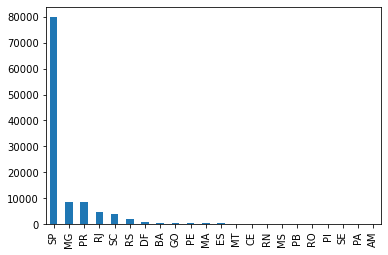

In [156]:
df['seller_state'].value_counts().plot.bar()

<AxesSubplot:ylabel='Frequency'>

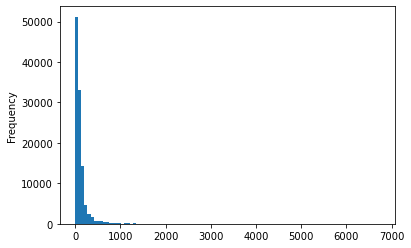

In [168]:
df['price'].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

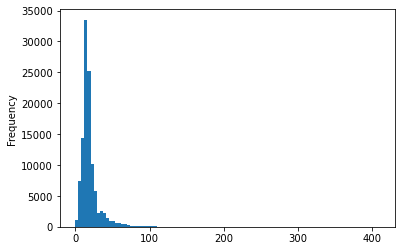

In [167]:
df['freight_value'].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

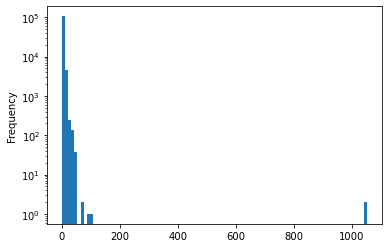

In [183]:
df['shipping_timelapse'].plot.hist(bins=100, logy=True)

<AxesSubplot:ylabel='Frequency'>

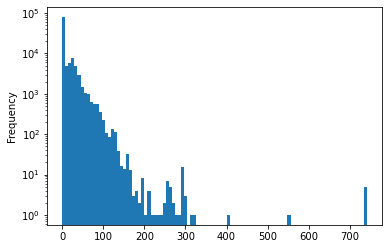

In [184]:
df['order_approved_timelapse'].plot.hist(bins=100, logy=True)

<AxesSubplot:ylabel='Frequency'>

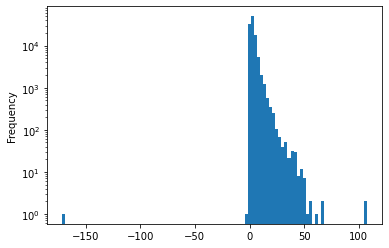

In [182]:
df['order_delivered_carrier_timelapse'].plot.hist(bins=100, logy=True)

<AxesSubplot:ylabel='Frequency'>

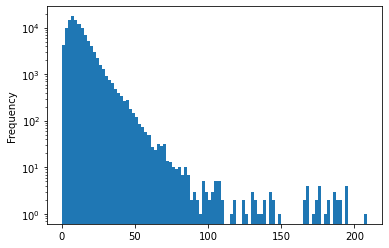

In [185]:
df['order_delivered_customer_timelapse'].plot.hist(bins=100, logy=True)

<AxesSubplot:ylabel='Frequency'>

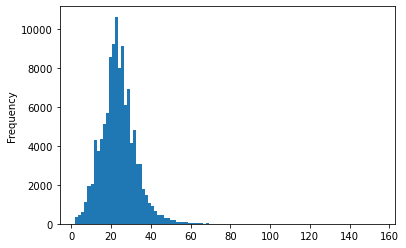

In [187]:
df['order_estimated_delivery_timelapse'].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

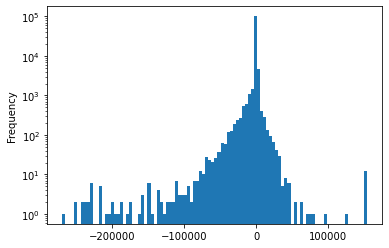

In [188]:
df['review_creation_timelapse_from_delivery'].plot.hist(bins=100, logy=True)

<AxesSubplot:ylabel='Frequency'>

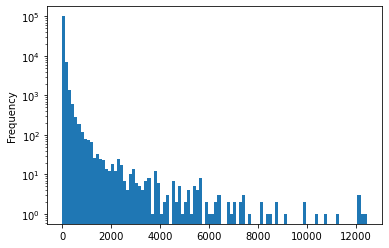

In [191]:
df['review_answer_timeslapse_from_review'].plot.hist(bins=100, logy=True)

In [205]:
df['price'].value_counts().sort_index()

0.85        3
1.20       20
2.20        2
2.29        1
2.90        1
2.99        1
3.06        3
3.49        3
3.50        6
3.54        1
3.85        4
3.90       15
3.98        6
3.99        2
4.20        2
4.30        5
4.40        4
4.50        7
4.90       16
4.99       10
5.00        3
5.18        2
5.20        5
5.30        4
5.31        7
           ..
2999.90     1
2999.99     2
3089.00     1
3099.00     1
3099.90     1
3105.00     1
3109.99     1
3124.00     2
3399.99     1
3549.00     1
3690.00     1
3699.99     1
3700.00     1
3899.00     2
3930.00     1
3999.00     2
3999.90     1
4059.00     1
4099.99     1
4399.87     1
4590.00     1
4690.00     1
4799.00     1
6499.00     1
6735.00     1
Name: price, Length: 5755, dtype: int64

In [198]:
df_unique_consumer = df.groupby('customer_unique_id').first()

In [320]:
# Zipping locations
lats = list(df_unique_consumer['geolocation_lat_customers'].dropna().values)[:30000]
longs = list(df_unique_consumer['geolocation_lng_customers'].dropna().values)[:30000]
locations = list(zip(lats, longs))


map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

FastMarkerCluster(data=locations).add_to(map1)

map1

NameError: name 'df_unique_consumer' is not defined

In [203]:


map2 = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: HeatMap
HeatMap(
    name='Mapa de Calor',
    data=locations,
    radius=10,
    max_zoom=13
).add_to(map2)

map2

In [207]:
df.head(10)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_sellers,geolocation_lng_sellers,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat_customers,geolocation_lng_customers,review_id,review_score,review_creation_date,review_answer_timestamp,delivery_against_estimated,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,month_year,month_y,shipping_timelapse,order_approved_timelapse,order_delivered_carrier_timelapse,order_delivered_customer_timelapse,order_estimated_delivery_timelapse,review_creation_timelapse_from_delivery,review_answer_timeslapse_from_review,order_purchase_time_day
0,b81ef226f3fe1789b1e8b2acac839d17,1,Credit Card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,19.53,13321,Salto,SP,-23.191965,-47.290258,Casa Construcao,57.0,921.0,8.0,800.0,17.0,27.0,17.0,Home Construction,0a8556ac6be836b46b3e89920d59291c,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22,708ab75d2a007f0564aedd11139c7708,39801.0,Teofilo Otoni,MG,-17.858065,-41.495279,4ce650e117a5b292bf5ea980a61eb61e,1.0,2018-05-10,2018-05-15 23:38:00,12.0,2018,4,2,22,Wed,Apr,2018-04,201804,7.000000,0.0,6.708333,13.791667,26.041667,383.0,143.0,Night
1,a9810da82917af2d9aefd1278f1dcfa0,1,Credit Card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,7.39,4660,Sao Paulo,SP,-23.665059,-46.679519,Automotivo,59.0,1274.0,2.0,150.0,16.0,6.0,11.0,Auto,f2c7fc58a9de810828715166c672f10a,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16,a8b9d3a27068454b1c98cc67d4e31e6f,2422.0,Sao Paulo,SP,-23.471749,-46.636773,ad2036caca61484fc435d7e673c020f2,5.0,2018-06-30,2018-07-03 11:23:16,16.0,2018,6,1,11,Tue,Jun,2018-06,201806,6.000000,0.0,2.125000,3.375000,19.500000,207.0,83.0,Morning
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,Credit Card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,8.72,9015,Santo Andre,SP,-23.659364,-46.523183,Perfumaria,54.0,1536.0,2.0,250.0,20.0,8.0,21.0,Perfumery,25b14b69de0b6e184ae6fe2755e478f9,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04,6f70c0b2f7552832ba46eb57b1c5651e,2652.0,Sao Paulo,SP,-23.457636,-46.656681,bcddfa0f7d2e54cfc74bae4f01b84d92,5.0,2017-12-19,2017-12-22 17:55:30,16.0,2017,12,1,11,Tue,Dec,2017-12,201712,13.916667,46.0,3.333333,6.250000,22.500000,395.0,89.0,Morning
3,ba78997921bbcdc1373bb41e913ab953,1,Credit Card,8,107.78,1,548e5bfe28edceab6b51fa707cc9556f,da8622b14eb17ae2831f4ac5b9dab84a,2017-12-12 12:13:20,89.90,17.88,13405,Piracicaba,SP,-22.708702,-47.664701,Cama Mesa Banho,60.0,188.0,1.0,1200.0,44.0,2.0,35.0,Bed Bath Table,7a5d8efaaa1081f800628c30d2b0728f,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04,87695ed086ebd36f20404c82d20fca87,36060.0,Juiz De Fora,MG,-21.741553,-43.335326,5bc7680443b4ef765fec11a8201eeb0c,5.0,2017-12-21,2017-12-22 01:10:39,13.0,2017,12,2,12,Wed,Dec,2017-12,201712,6.000000,0.0,1.333333,14.541667,28.458333,-96.0,25.0,Morning
4,42fdf880ba16b47b59251dd489d4441a,1,Credit Card,2,128.45,1,386486367c1f9d4f587a8864ccb6902b,cca3071e3e9bb7d12640c9fbe2301306,2018-05-31 16:14:41,113.57,14.88,14940,Ibitinga,SP,-21.757321,-48.829744,Cama Mesa Banho,54.0,120.0,1.0,835.0,40.0,9.0,33.0,Bed Bath Table,15fd6fb8f8312dbb4674e4518d6

In [214]:
df['product_category_name_english'].value_counts()

Bed Bath Table                             11485
Health Beauty                               9623
Sports Leisure                              8642
Furniture Decor                             8377
Computers Accessories                       7825
Housewares                                  7100
Watches Gifts                               5990
Telephony                                   4535
Garden Tools                                4419
Auto                                        4223
Toys                                        4096
Cool Stuff                                  3823
Perfumery                                   3419
Baby                                        3067
Electronics                                 2692
Stationery                                  2535
Fashion Bags Accessories                    2080
Pet Shop                                    1969
Office Furniture                            1727
Luggage Accessories                         1140
Consoles Games      